In [1]:
import io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
embedding_layer = layers.Embedding(1000, 5)
res = embedding_layer(tf.constant([1, 2, 3]))

In [3]:
print(res.numpy())
print(res.numpy().shape)

[[ 0.02034261  0.01418148  0.01450272 -0.02278354 -0.00159033]
 [ 0.02980829 -0.01760842 -0.03564744 -0.02596173 -0.02811578]
 [ 0.03851149 -0.02528358  0.0008427  -0.03953675 -0.02101711]]
(3, 5)


In [4]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    data_dir='dataset', with_info=True, as_supervised=True
)

In [5]:
encoder = info.features['text'].encoder

In [6]:
print(encoder.subwords[:25])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_']


In [7]:
padded_shapes = ([None], ())

In [8]:
BATCH_SIZE = 32

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)

In [10]:
EMBEDDING_DIM = 16

In [11]:
model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, EMBEDDING_DIM),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(train_batches, epochs=10, validation_data=test_batches, validation_steps=20, workers=-1)

Epoch 1/10
782/782 [==============================] - 14s 18ms/step - loss: 0.6835 - accuracy: 0.6043 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 11s 14ms/step - loss: 0.6215 - accuracy: 0.7467 - val_loss: 0.5873 - val_accuracy: 0.7797
Epoch 3/10
782/782 [==============================] - 11s 14ms/step - loss: 0.5412 - accuracy: 0.8064 - val_loss: 0.5261 - val_accuracy: 0.7906
Epoch 4/10
782/782 [==============================] - 10s 13ms/step - loss: 0.4723 - accuracy: 0.8372 - val_loss: 0.4474 - val_accuracy: 0.8422
Epoch 5/10
782/782 [==============================] - 10s 13ms/step - loss: 0.4212 - accuracy: 0.8620 - val_loss: 0.4379 - val_accuracy: 0.8313
Epoch 6/10
782/782 [==============================] - 10s 13ms/step - loss: 0.3792 - accuracy: 0.8761 - val_loss: 0.3969 - val_accuracy: 0.8813
Epoch 7/10
782/782 [==============================] - 11s 14ms/step - loss: 0.3485 - accuracy: 0.8854 - val_loss: 0.3822 - val_a

In [18]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

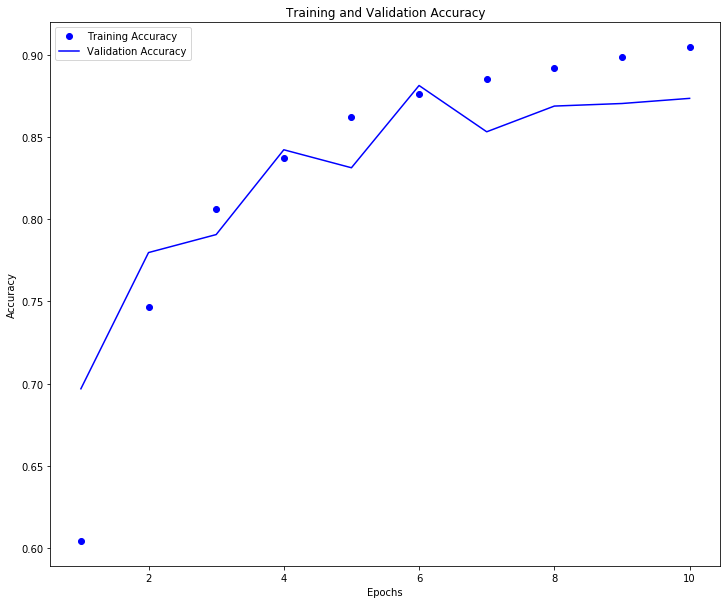

In [19]:
plt.figure(figsize=(12, 10))
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [20]:
out_vectors = io.open('outputs/we_vecs.tsv', 'w', encoding='utf-8')
out_metadata = io.open('outputs/we_meta.tsv', 'w', encoding='utf-8')
weights = model.layers[0].get_weights()[0]

for num, word in enumerate(encoder.subwords):
    vec = weights[num + 1]
    out_metadata.write(word + '\n')
    out_vectors.write('\t'.join([str(x) for x in vec]) + '\n')

out_metadata.close()
out_vectors.close()